# Propagation through turbulent atmosphere

This notebook is intended to give quick access to poppy's capabilities to simulate the propagation of a wavefront through a turbulent atmosphere.

## Turbulent phase screens

Turbulent phase screens have been implemented within Kolmogorov's theory of turbulence, which is a statistical description of a homogenous and isotropic atmosphere. To describe a particular atmosphere is therefore based on random numbers with only one restriction: An ensemble average (average over a multitude of different realizations of the atmosphere) must reproduce a specific longitudinal structure function for which Kolmogorov showed that it obeys a universal power law. From the structure function, one can derive the spatial power spectral density $\phi_n$ which is usually used to describe the state of the atmosphere. The strength of the turbulent atmosphere is characterized by either the Fried parameter $r_0$ or the index-of-refraction structure constant $C_n^2$. One can obtain one from the other.

The algorithmic implementation for turbulence is mainly based on this paper (but beware, it has **a LOT** of typos):

Fleck, J. A., Jr, Morris, J. R. & Feit, M. D. *Time-dependent propagation of high energy laser beams through the atmosphere*. Appl. Phys. **10**, 129–160 (1976).

It introduces the split-step propagation method in which the propagation distance is divided into intervals. After propagating the wavefront the next interval, the accumulated distortions originating from the turbulent atmosphere are considered as a thin phase screen applied in the middle of this interval. Therefore, to generate a phase screen, the interval length is required. Also, the wavelength and of course the spatial power spectral density are of importance. Here, a variety have been implemented: Kolmogorov, Tatarski, van Karman, and the Hill spectrum (for more details, see the code).

Now let us take a look at such a phase screen and start by defining a wavefront and characterizing the atomsphere:

Oversampling > 2x suggested for reliable results.


(<matplotlib.axes._subplots.AxesSubplot at 0x119e3bf98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b073e48>)

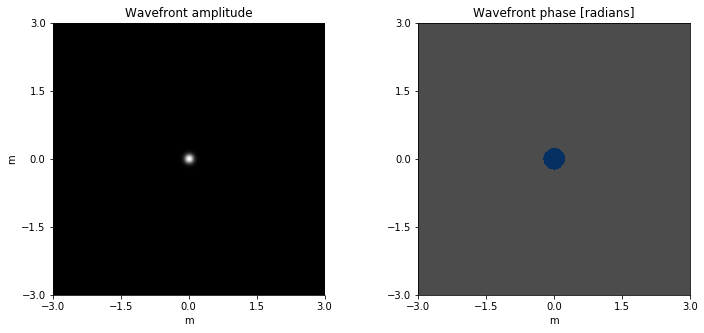

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from copy import deepcopy
import poppy


# define beam parameter
w0 = 10*u.cm              # beam radius
L = 1*u.km                # propagation distance
w_extend = 30              # weight of the spatial extend
wavelength = 1064*u.nm    # wavelength in vacuum
npix = 512                # number of pixels
oversample = 1            # oversmaple
Cn2 = 1.0e-14*u.m**(-2/3) # index-of-refraction structure constant
nz = 20                   # number of phase screens
dz = L/nz                 # propagation step

# create wavefront
wf = poppy.FresnelWavefront(beam_radius=w_extend*w0,
                            wavelength=wavelength,
                            units=u.m,
                            npix=npix,
                            oversample=oversample)
wf *= poppy.GaussianAperture(w=w0)
wf *= poppy.QuadraticLens(f_lens=1.01*L)

wf0 = deepcopy(wf)

plt.figure(figsize=(12,5))
wf.display('both')

Now, let us generate a single phase screen and visualize it:

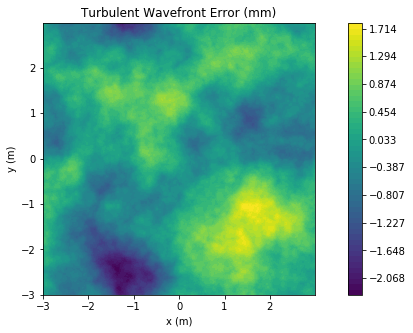

In [2]:
# generate a Kolmogorov wavefront error object
phase_screen = poppy.KolmogorovWFE(Cn2=Cn2, dz=dz)

# get optical path difference (mm)
opd = phase_screen.get_opd(wf)*1e6

# get current coordinates
y, x = wf.coordinates()

# plot
fig = plt.figure(figsize=(12,5))
num_levels = 50
levels = np.linspace(np.min(opd), np.max(opd), num_levels)
ax = fig.add_subplot(111)
cf = ax.contourf(x, y, opd, levels=levels)
ax.set_aspect('equal')
ax.set_title('Turbulent Wavefront Error (mm)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.colorbar(cf)

Rerunning the above cell will result in ever changing phase screens because it is based on randon numbers and the seed for the random number generator has not been fixed. The figure shows an example of a wavefront error that is accumulated over a 50m distance for a wavelength of 1064nm and an index-of-refraction structure constant $C_n^2=1\times 10^{-14}$m$^{-2/3}$.

## Propagation through turbulent atmosphere

Let us now see how the wavefront changes when it propagates through a turbulent atmosphere. Note that within the framework of the split-step propagation method, we first propagate a half step and then full steps while the last propagation step is again a half step.

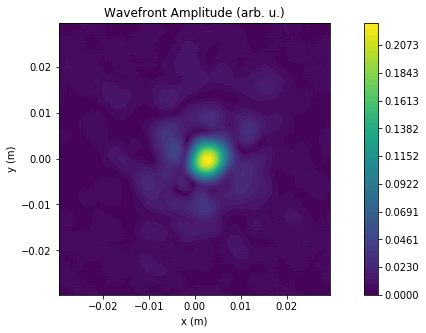

In [3]:
wf = deepcopy(wf0)

for l in range(nz+1):
    if l==0 or l==nz:
        wf.propagate_fresnel(dz/2)
        phase_screen = poppy.KolmogorovWFE(Cn2=Cn2, dz=dz/2)
    else:
        wf.propagate_fresnel(dz)
        phase_screen = poppy.KolmogorovWFE(Cn2=Cn2, dz=dz)
    
    wf *= phase_screen

fig = plt.figure(figsize=(12,5))
fig.clf()
y, x = wf.coordinates()
z = wf.amplitude
levels = np.linspace(np.min(z), np.max(z), num_levels)
ax = fig.add_subplot(111)
cf = ax.contourf(x, y, z, levels=levels)
ax.set_aspect('equal')
ax.set_title('Wavefront Amplitude (arb. u.)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.colorbar(cf)

Turbulence has two important implications. First, the intensity distribution gets disrupted. This can even lead to branch points at pixels where the intensity vanishes. Secondly, the beam center shifts due to the low-frequency contributions of the power spectral density.

## To-Do

This section is just a reminder for myself.

1. Some important things are not yet implemented. Most importantly, this is the inclusion of low frequency components which need a massive numerical resolution at the moment. This can be done better by methods like an additional big phase screen or subharmonics.

2. Check the structure function of the phase screens.

3. Check the beam radius vs analytical result.